In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headline/news.csv


In [2]:
%config Completer.use_jedi = False

In [3]:
# 📊 BERT Sentiment Analysis with Cross-Validation

# =============================================================================
# 📚 IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
import warnings
import re
warnings.filterwarnings('ignore')

print("Libraries imported! 🎉")
print(f"CUDA available: {torch.cuda.is_available()}")


2025-10-28 11:46:26.649540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761651986.879206      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761651986.941661      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported! 🎉
CUDA available: False


In [4]:
# =============================================================================
# 📁 DATA LOADING & PREPROCESSING
# =============================================================================

df = pd.read_csv('/kaggle/input/news-headline/news.csv', encoding='iso-8859-1')


In [5]:
print("Dataset Shape")
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.\n")

Dataset Shape
The dataset has 4846 rows and 2 columns.



In [6]:
print("--- Column Information ---")
df.info()

--- Column Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [7]:
# --- Check for Missing Values ---
print("\n--- Missing Values Check ---")
print(df.isnull().sum())


--- Missing Values Check ---
sentiment    0
headline     0
dtype: int64


In [8]:
# --- Check for Duplicate Headlines ---
duplicate_count = df.duplicated(subset=['headline']).sum()
print(f"\n--- Duplicate Headlines Check ---")
print(f"There are {duplicate_count} duplicate headlines in the dataset.")


--- Duplicate Headlines Check ---
There are 8 duplicate headlines in the dataset.


In [9]:
# Let's remove them to avoid biasing the model
df.drop_duplicates(subset=['headline'], inplace=True, keep='first')
print(f"Shape after removing duplicates: {df.shape}")

Shape after removing duplicates: (4838, 2)


# Sentiment Distribution

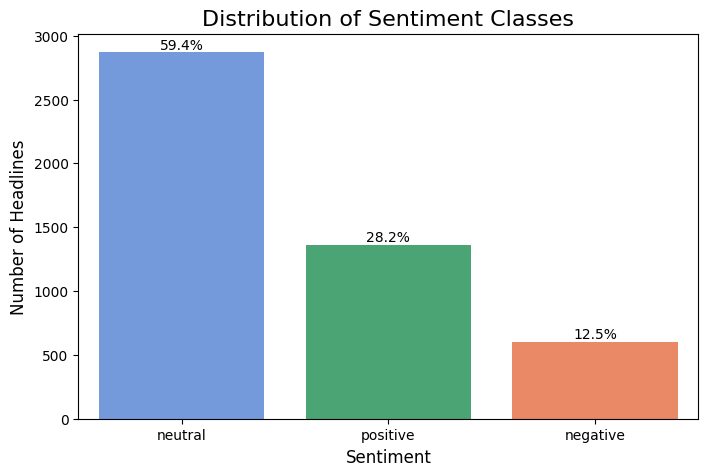

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette=['#6495ED', '#3CB371', '#FF7F50'], order=['neutral', 'positive', 'negative'])
plt.title('Distribution of Sentiment Classes', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Headlines', fontsize=12)

# Add percentages on top of the bars
total = len(df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.gca().annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

# Headline Analysis (The Feature Variable)
## Headline Length Analysis

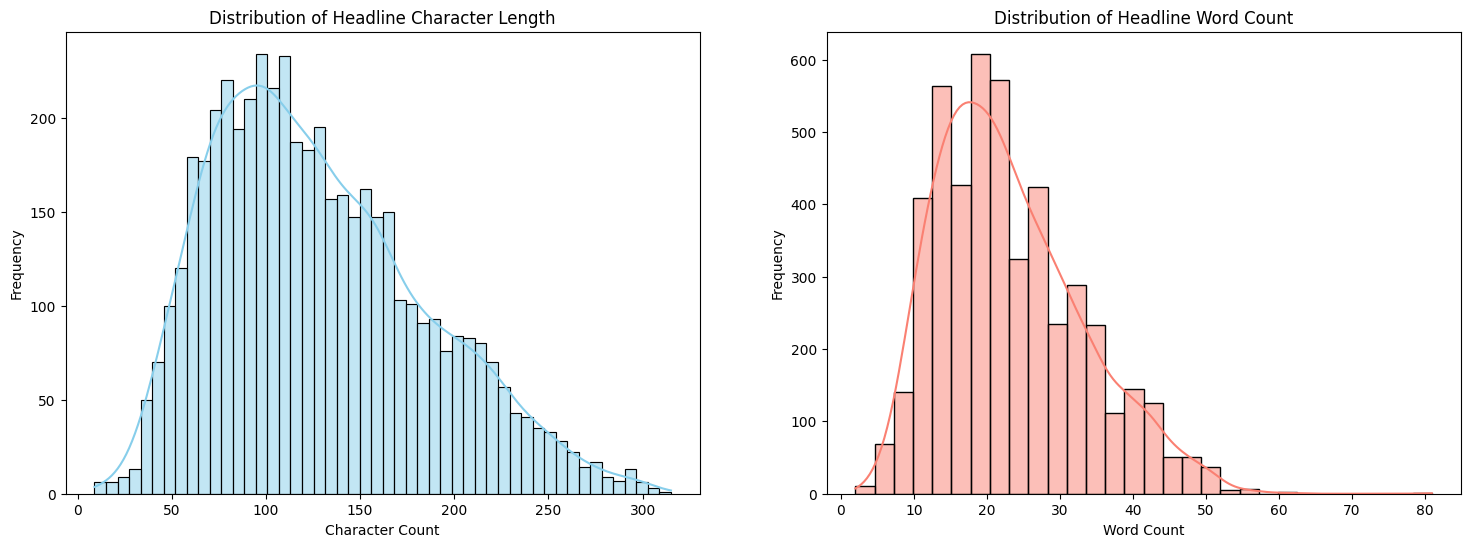


--- Summary Statistics for Headline Length ---
       char_length   word_count
count  4838.000000  4838.000000
mean    128.059529    23.089913
std      56.405552     9.938990
min       9.000000     2.000000
25%      84.000000    16.000000
50%     119.000000    21.000000
75%     163.000000    29.000000
max     315.000000    81.000000


In [11]:
# Create new columns for character and word counts
df['char_length'] = df['headline'].str.len()
df['word_count'] = df['headline'].apply(lambda x: len(x.split()))

# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


# Character Length
sns.histplot(df['char_length'], bins=50, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Headline Character Length')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')


# Word Count
sns.histplot(df['word_count'], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Distribution of Headline Word Count')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')



plt.show()

print("\n--- Summary Statistics for Headline Length ---")
print(df[['char_length', 'word_count']].describe())

## Common Words and Phrases (N-gram Analysis)

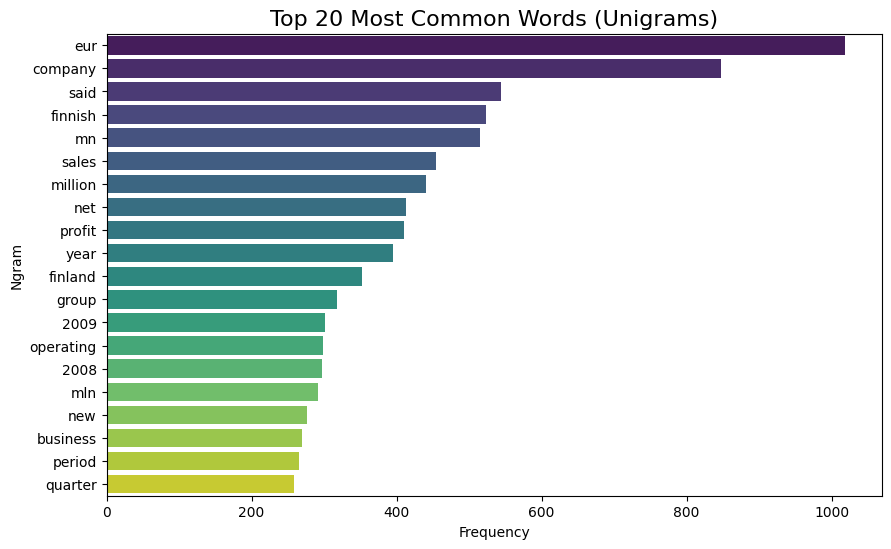

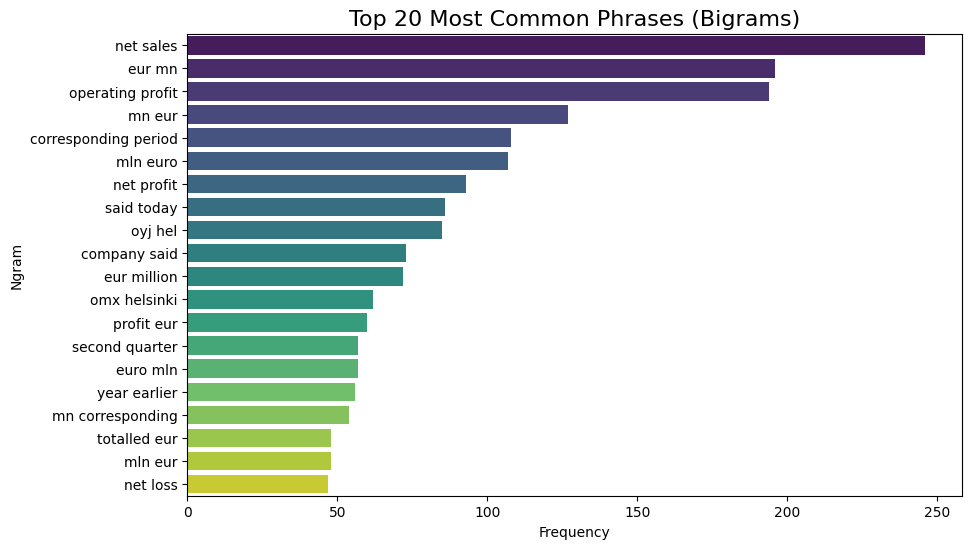

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Helper function to get and plot top n-grams
def plot_top_ngrams(corpus, title, n=20, ngram_range=(1,1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    top_df = pd.DataFrame(words_freq[:n], columns=['Ngram', 'Frequency'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Ngram', data=top_df, palette='viridis')
    plt.title(title, fontsize=16)
    plt.show()

# --- Top 20 most common words (unigrams) across all headlines ---
plot_top_ngrams(df['headline'], 'Top 20 Most Common Words (Unigrams)', n=20, ngram_range=(1,1))



# --- Top 20 most common phrases (bigrams) across all headlines ---
plot_top_ngrams(df['headline'], 'Top 20 Most Common Phrases (Bigrams)', n=20, ngram_range=(2,2))



## Most Common Words by Sentiment

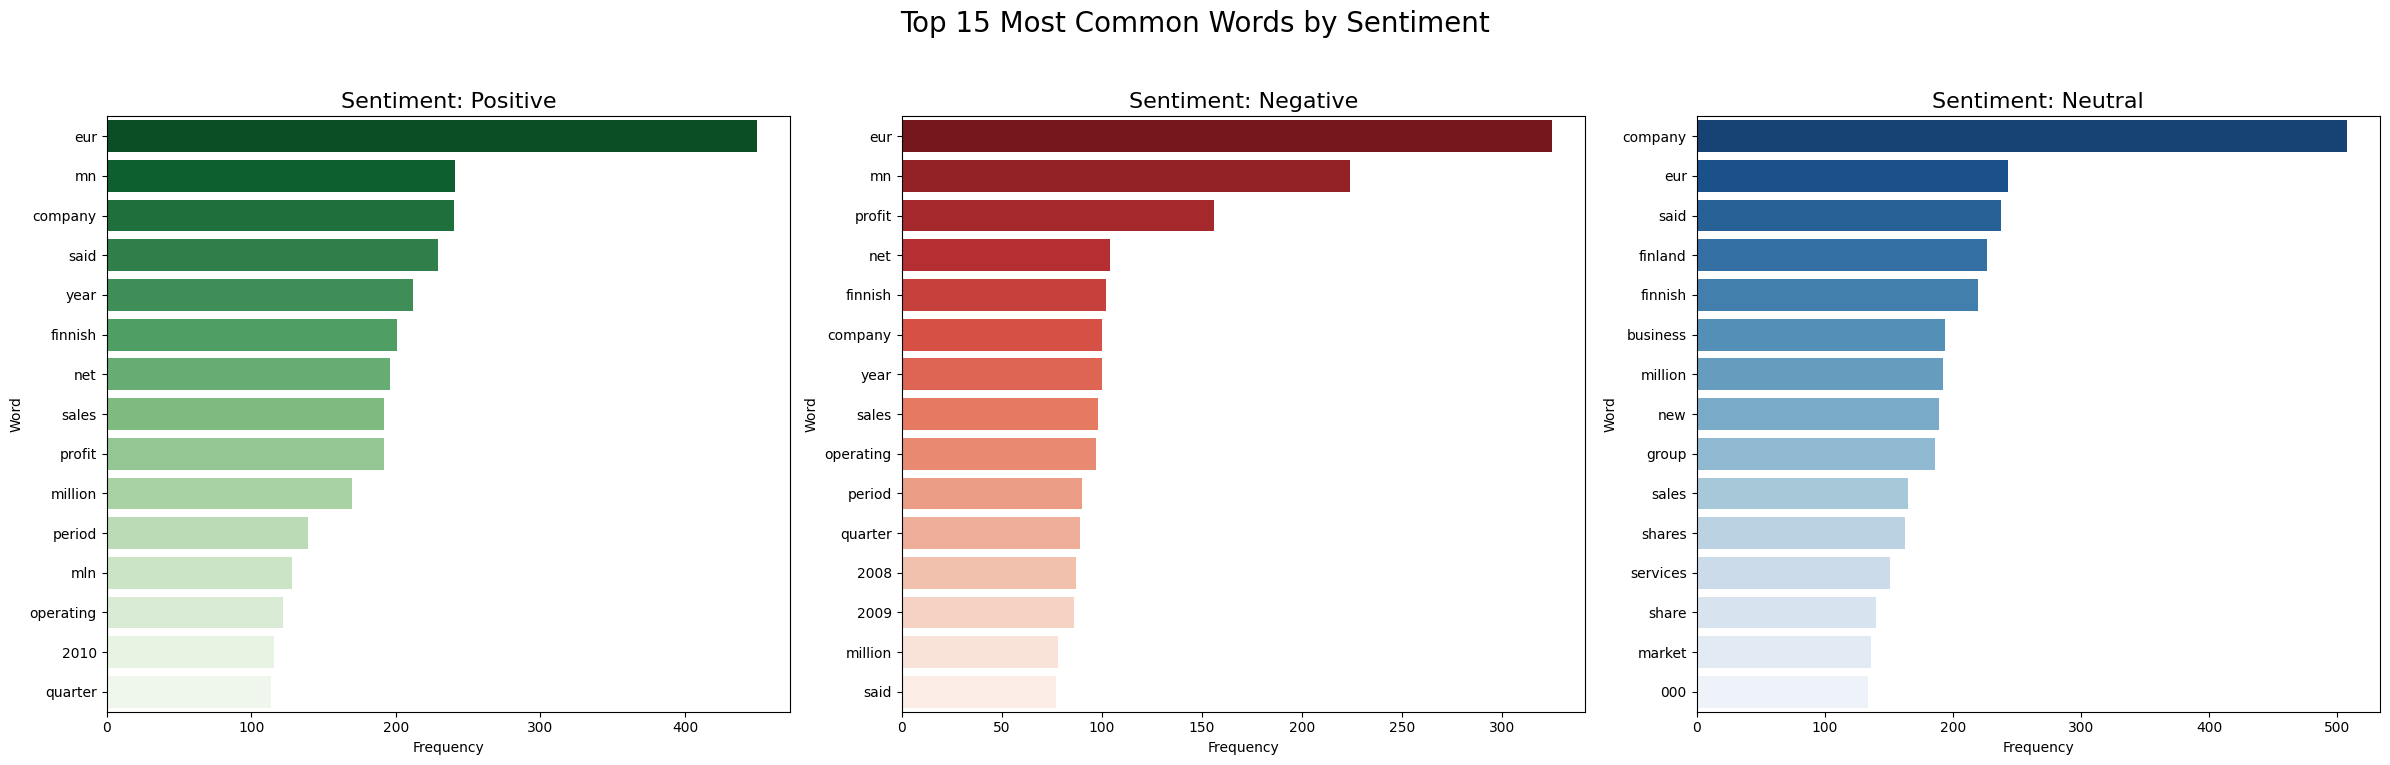

False

In [13]:
# Create separate plots for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Top 15 Most Common Words by Sentiment', fontsize=20)

sentiments = ['positive', 'negative', 'neutral']
palettes = ['Greens_r', 'Reds_r', 'Blues_r']

for i, sentiment in enumerate(sentiments):
    corpus = df[df['sentiment'] == sentiment]['headline']
    
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    top_df = pd.DataFrame(words_freq[:15], columns=['Word', 'Frequency'])
    
    sns.barplot(x='Frequency', y='Word', data=top_df, palette=palettes[i], ax=axes[i])
    axes[i].set_title(f'Sentiment: {sentiment.capitalize()}', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()is re

## Word Clouds by Sentiment

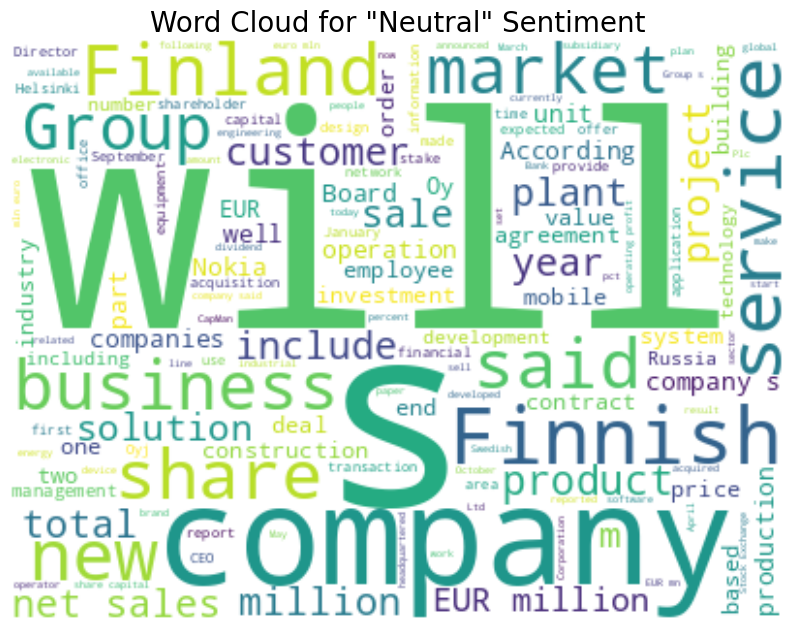

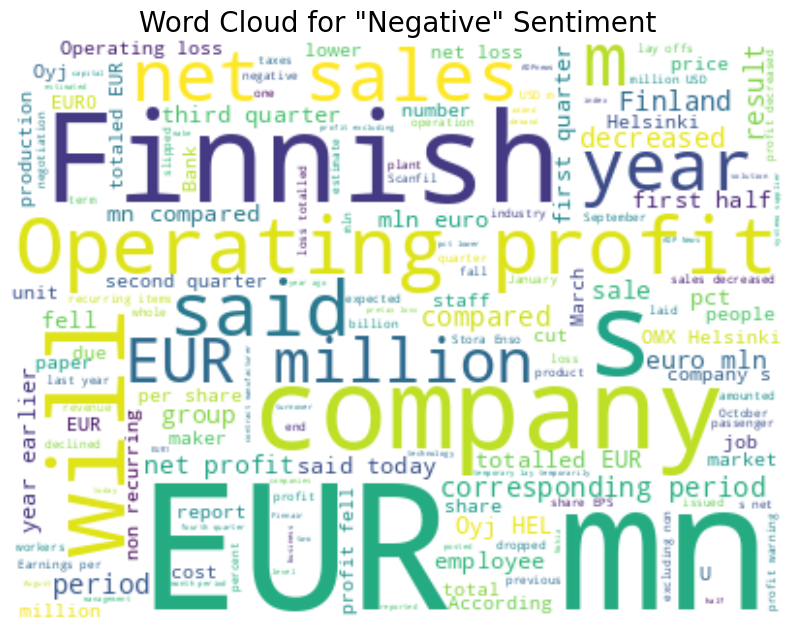

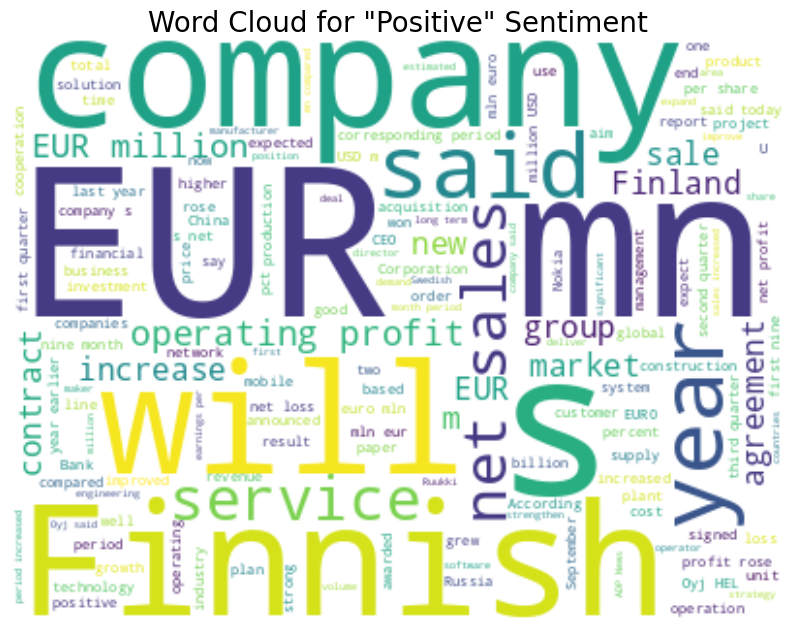

In [14]:
# You may need to install the wordcloud library first
# !pip install wordcloud

from wordcloud import WordCloud

# Create a function to generate and plot a word cloud
def generate_wordcloud(data, title):
    wc = WordCloud(width=400, 
                   height=300, 
                   max_words=150, 
                   background_color='white',
                   colormap='viridis' # Using a single colormap for consistency
                  ).generate(str(data))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Generate a word cloud for each sentiment
for sentiment in df['sentiment'].unique():
    # Combine all headlines for the current sentiment into one long string
    text = ' '.join(df[df['sentiment'] == sentiment]['headline'])
    
    # Create the word cloud
    generate_wordcloud(text, f'Word Cloud for "{sentiment.capitalize()}" Sentiment')

## Characteristic Words by Sentiment (Using TF-IDF)

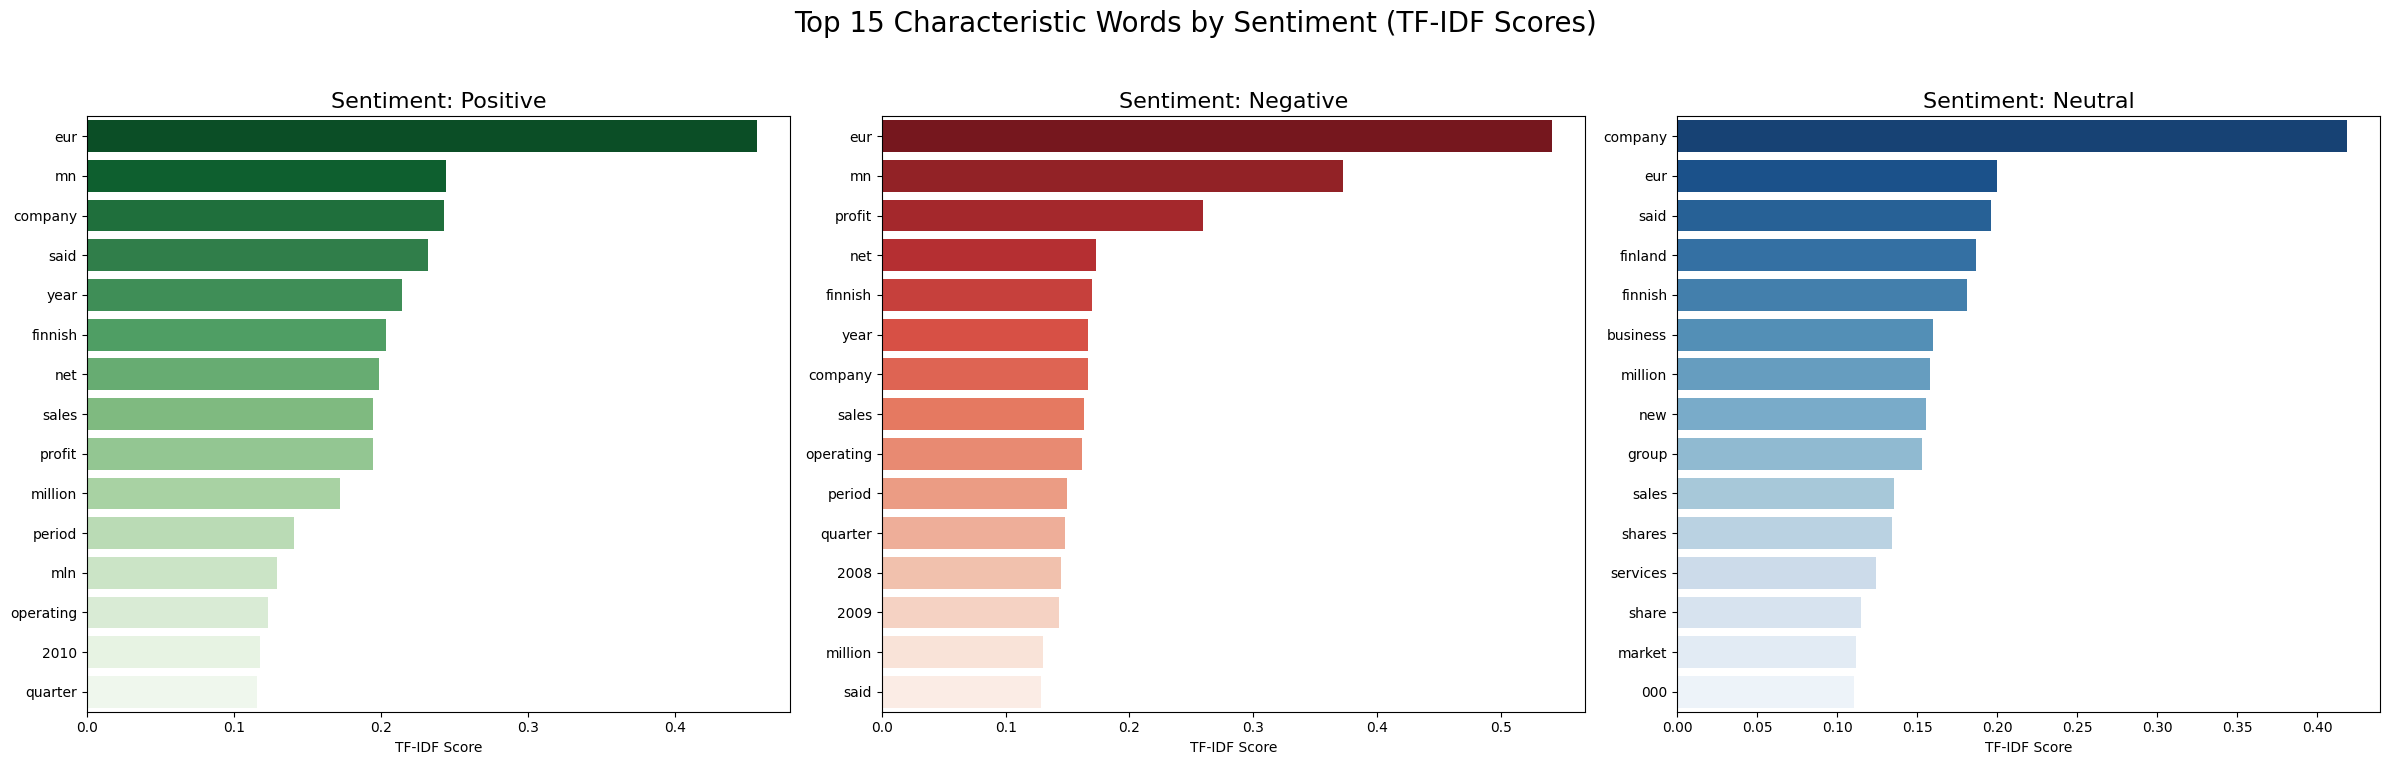

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# We will treat each sentiment group as a "document"
documents = [
    ' '.join(df[df['sentiment'] == 'positive']['headline']),
    ' '.join(df[df['sentiment'] == 'negative']['headline']),
    ' '.join(df[df['sentiment'] == 'neutral']['headline'])
]
sentiments = ['Positive', 'Negative', 'Neutral']

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_features=1000)

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Get feature names (the words)
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Create a DataFrame for the TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=sentiments, columns=feature_names)

# Plot the top 15 characteristic words for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Top 15 Characteristic Words by Sentiment (TF-IDF Scores)', fontsize=20)

palettes = ['Greens_r', 'Reds_r', 'Blues_r']

for i, sentiment in enumerate(sentiments):
    # Get the top 15 words for the current sentiment
    top_words = tfidf_df.loc[sentiment].sort_values(ascending=False)[:15]
    
    sns.barplot(x=top_words.values, y=top_words.index, palette=palettes[i], ax=axes[i])
    axes[i].set_title(f'Sentiment: {sentiment}', fontsize=16)
    axes[i].set_xlabel('TF-IDF Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()